# CIS 1902 Homework 5: Deep Learning

Welcome to Homework 5! This homework will be focused on deep learning. In this homework, you will be using a variety of tools and libraries that you have learned in lecture to build deep learning models, that actually solve real-world problems. Deep learning has tons of applications, ranging from voice recognition to image recognition to natural language processing.


The foundation of deep learning is the neural network and the convolutional neural network (CNN). The neural network is a series of layers that are connected to one another, which borrows from the structure of the human brain. The CNN is a type of neural network that is particularly good at image recognition, and at a high-level is a parametric model with usually a huge number of parameters.

While the neural network model is comprehensible to us, it introduces a new set of terminologies. Utilizing this model, we'll establish its architecture, including input, hidden, and output layers, and apply it to various real-world problems.

Given that deep learning's primary successes lie in image recognition, language processing, and similar fields, we'll also delve into Convolutional Neural Networks (CNNs), specialized for image processing. We'll compare its performance to traditional neural networks.


## Part 1: Importing Libraries

Let's start by importing the libraries that we will be using in this homework.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch
from torchvision import datasets, transforms
from torch.utils.data import Subset
from collections import Counter
from PIL import Image
from skimage import io, transform
import os
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import math

Next, let's setup GPU capabilities for our notebook. The cell below sets up a CUDA device to use with torch, if it is available. If you are using Google Colab, you can enable GPU acceleration by going to `Runtime` -> `Change runtime type` and selecting `GPU` as the hardware accelerator.

Note that you can create a PyTorch tensor T that resides on the GPU using the command T = torch.Tensor(..., device=cuda). You can also copy existing tensors to the GPU using the to method, e.g. T.to(device) (make sure to overwrite T with the result of the function call). If you do not have a GPU, these commands will not work and you will need to use the CPU.


In [ ]:
torch.manual_seed(42)  # For grading consistency
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

2.2.1+cu121
cuda:0


In [ ]:
device

device(type='cuda', index=0)

In [ ]:
# Test Case #1
# check that device is set to cuda if available
if torch.cuda.is_available():
    if str(device) == "cuda:0":
        print("Test Case 1 Passed")
    else:
        print("Test Case 1 Failed")
else:
    print("Test Case 1 Passed")

Test Case 1 Passed


The real-world problem we will be solving in this homework is the classification of images, or more specifically, the classification of handwritten digits. We will be using the MNIST dataset, which is a dataset of 28x28 grayscale images of handwritten digits (0-9). The dataset contains 60,000 training images and 10,000 testing images. The goal is to build a model that can accurately classify these images into their respective digits.

We will be using the dataset to train 3 models and compare their performance on the test set. The models we will be using are:

1. Logistic Regression
2. Neural Network
3. Convolutional Neural Network


<div>
<img src="https://s2.loli.net/2023/03/26/GwFJhNeskzE5Ptx.webp", width="800"/>
</div>


## Part 2: Data Preprocessing (PyTorch Dataset and DataLoader)

To ensure consistency in data loading across various models, PyTorch offers two essential components: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset`. These primitives facilitate the utilization of pre-loaded datasets and custom data.

The `Dataset` module manages samples along with their respective labels, while `DataLoader` encapsulates an iterable structure around the `Dataset`, simplifying sample access. Additional details and practical examples of these components can be explored in the PyTorch documentation.

While PyTorch furnishes `Dataset` and `DataLoader` for several popular datasets, custom `Dataset` creation might be necessary for specific data processing requirements. PyTorch also provides a catalog of built-in datasets, which can be accessed through the official documentation.

The `Dataset` class encompasses three key components:

- `__init__`: This method is responsible for setting up the parameters used within the class, such as transforms, which corresponds to the applied transformations.
- `__len__`: Its purpose is to ensure that `len(dataset)` returns the dataset's size.
- `__getitem__`: This function supports indexing, allowing `dataset[i]` to retrieve the i-th sample (in the case of images, this would typically be an image-label pair).

Custom `Dataset` creation involves overriding the aforementioned functions.

Documentation on creating custom datasets can be accessed here.

Fortunately, for classic image datasets like MNIST, the need for creating custom `Dataset` and `DataLoader` objects is eliminated, as PyTorch includes them by default upon import.


**TODO**: Implement the following sequence of transformations using `transforms.Compose`, and assign the resulting transformation pipeline to the variable `transform`:

1.  **Resize**: Adjust the dimensions of each image in the dataset to 28x28 pixels, ensuring a consistent size across all images.
2.  **ToTensor**: Convert the images into PyTorch tensors, facilitating their use within the framework.
3.  **RandomRotation**: Apply a random rotation to each image within a range of -45° to 45°, introducing variability to the dataset.
4.  **RandomPerspective**: Introduce a random perspective transformation with a distortion scale of 0.3 to approximately half of the images (50% probability).
5.  **Normalize**: Standardize the tensor images using a mean of 0.1307 and a standard deviation of 0.3081, adjusting pixel values for more effective model training.

---

**NOTE**: For a comprehensive understanding of how each transformation works and to see examples in action, it is strongly advised to consult the [PyTorch documentation on transformations](https://pytorch.org/vision/stable/transforms.html) and explore [visual illustrations of transformations](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html) provided by PyTorch.


In [ ]:
# TODO: Define the transform

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=45),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.Normalize((0.1307,), (0.3081,))
])

Now that we have defined the transforms we are going to apply to the dataset, let's instantiate `Dataset` objects for both the training and testing sets using predefined PyTorch Datasets. You can refer to the documentation [here](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html).

Considering the whole dataset is quite large for running the model efficiently, we will also downsample by reducing the size of the dataset by half.

---

**TODO**:

- Initiate the `Dataset` object for the training set as `train_dataset`.
- Downsample the training dataset by getting the data at even-numbered indices, specified as `train_subset`.
- Initiate the `Dataset` object for the testing set as `test_dataset`.
- Downsample the testing dataset by getting the data at even-numbered indices, specified as `test_subset`.

---

**Hint**: Check out [`torch.utils.data.Subset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset) for downsampling the dataset.

**Note**: When initiating the `Dataset` object for both the training and testing sets, in addition to other arguments, please set these arguments as follows:

- `root = './data'`
- `download = True`


In [ ]:
root = './data'


# TODO: Initiate the Dataset object for the training set as train_dataset
train_dataset = datasets.MNIST(root=root, train=True, transform=transform, download=True)

# TODO: Downsample training by getting the train data at even-numbered indices, specified as train_subset
train_subset = Subset(train_dataset, indices=range(0, len(train_dataset), 2))

# TODO: Initiate the dataset object for the test set as test_dataset
test_dataset = datasets.MNIST(root=root, train=False, transform=transform, download=True)

# TODO: Downsample test by getting the test data at even-numbered indices, specified as test_subset
test_subset = Subset(test_dataset, indices=range(0, len(test_dataset), 2))

100%|██████████| 9912422/9912422 [00:00<00:00, 133825099.28it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 41188607.22it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 45221411.83it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23007884.99it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



With `trainDataset` and `testDataset` prepared, it's time to set up dataloaders for both datasets.

Utilize the `DataLoader` class to encapsulate the datasets into dataloaders. For more detailed instructions, consult the [DataLoader documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

---

**TODO**:

- Create a `DataLoader` instance for `train_subset` named `train_loader`.
- Create a `DataLoader` instance for `test_subset` named `test_loader`.

---

**NOTE**: When initializing the `DataLoader` instances, ensure to configure the `batch_size` to match the value of the `batch` variable previously established. Also, enable `shuffle` by setting it to `True` and set `num_workers` to 0.


In [ ]:
batch = 64

# TODO: Initiate the DataLoader object for the training set as train_loader
train_loader = DataLoader(train_subset, batch_size=batch, shuffle=True, num_workers=0)

# TODO: Initiate the DataLoader object for the test set as test_loader
test_loader =DataLoader(test_subset, batch_size=batch, shuffle=True, num_workers=0)

## Part 3: Data Summary and Visualization

Now that we have our dataset, let's take some time to understand the data we are working with. We will visualize some of the images in the dataset and understand the distribution of the labels in the dataset.

**TODO**

- **Train**

  - Determine the count of distinct labels present in the training dataset and assign this value to `train_num_labels`.
  - Instantiate a `DataLoader` named `train_loader_bar_plot` using `train_subset`, configured with:
    - `batch_size` set to the total number of items in `train_subset`
    - `shuffle` enabled (`True`)
    - `num_workers` set to 0
  - Construct a dictionary named `train_subset_dict` where each key represents a label, and the corresponding value is the count of images under that label.

- **Test**

  - Identify the total number of unique labels in the testing dataset and store this figure in `test_num_labels`.
  - Establish a `DataLoader` named `test_loader_bar_plot` for `test_subset`, with the settings:
    - `batch_size` equal to the size of `test_subset`
    - `shuffle` activated (`True`)
    - `num_workers` as 0
  - Create a dictionary `test_subset_dict` mapping each label to the quantity of images associated with that label.


In [ ]:
train_num_labels = len(train_dataset.classes)

test_num_labels = len(test_dataset.classes)

train_loader_bar_plot =  DataLoader(train_subset, batch_size=len(train_subset), shuffle=True, num_workers=0)

test_loader_bar_plot = DataLoader(test_subset, batch_size=len(test_subset), shuffle=True, num_workers=0)

train_subset_dict = {label: 0 for label in train_dataset.classes}
for images, labels in train_loader_bar_plot:
    for label in labels:
        train_subset_dict[train_dataset.classes[label]] += 1

test_subset_dict =  {label: 0 for label in test_dataset.classes}
for images, labels in test_loader_bar_plot:
    for label in labels:
        test_subset_dict[test_dataset.classes[label]] += 1

Now we are going to use the matplotlib skills we worked on in the last homework, to visualize the data.

**TODO:**

- Construct a bar plot to visualize the frequency distribution of labels in the training dataset. Use `train_subset_dict` for data, set the x-axis label to `Labels`, the y-axis label to `Frequency`, and the plot title to `Distribution of Training Set Labels`.
- Similarly, generate a bar plot for the label frequency distribution in the testing dataset using `test_subset_dict`. Label the x-axis as `Labels`, the y-axis as `Frequency`, and title the plot `Distribution of Testing Set Labels`.
- Ensure each bar displays its label count above it (for example, a bar representing label 1 with 1200 instances should have "1200" displayed above).
- To keep the file size manageable for submission, adjust the figure size to (8,6).

---

**NOTE:**

- The y-axis represents the total number of instances per label.
- The x-axis should denote the numerical value of the labels found in the MNIST dataset.


In [ ]:
# Train Subset Bar Plot

In [ ]:
# Test Subset Bar Plot

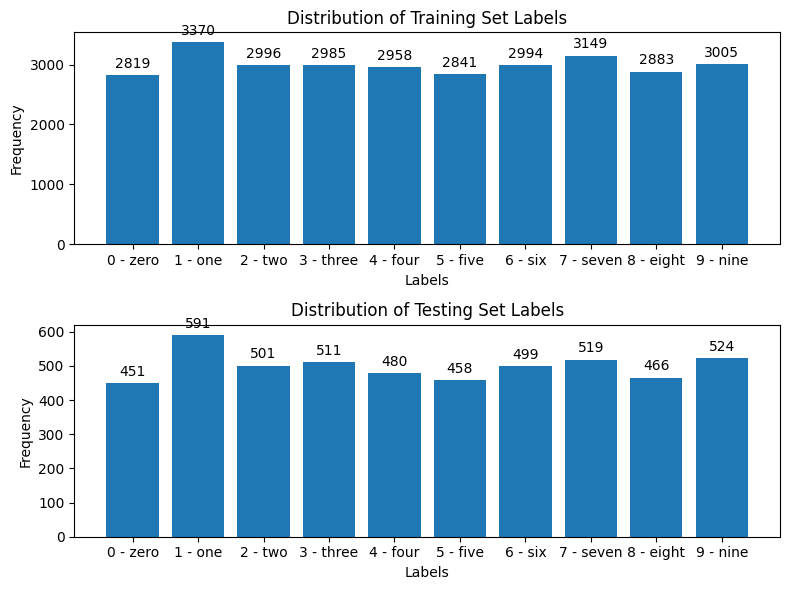

In [ ]:
def add_labels(ax):
    for rect in ax.patches:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.figure(figsize=(8, 6))
ax1 = plt.subplot(2, 1, 1)
ax1.bar(train_subset_dict.keys(), train_subset_dict.values())
ax1.set_title('Distribution of Training Set Labels')
ax1.set_xlabel('Labels')
ax1.set_ylabel('Frequency')
add_labels(ax1)

ax2 = plt.subplot(2, 1, 2)
ax2.bar(test_subset_dict.keys(), test_subset_dict.values())
ax2.set_title('Distribution of Testing Set Labels')
ax2.set_xlabel('Labels')
ax2.set_ylabel('Frequency')
add_labels(ax2)

plt.tight_layout()
plt.show()

Now, let's visualize some of the images in the dataset. Take some arbitrary indices, and print out 6 of the images in the training set.

**TODO**

- Iterate over `train_dataset` using a list of arbitrary indices (length: 6) with a for-loop.
- Within each iteration of this loop:
  - Display the image at the current index from `train_dataset` as a grayscale image. Use a 2 by 3 subplot arrangement for plotting, leveraging matplotlib.
  - Use `plt.title` to label each subplot with the corresponding image label from the dataset.
  - Ensure that grid lines and axis labels are not visible in the plots.
- To keep the file size suitable for submission, set the total figure size to (8,4). Note that this size refers to the overall figure, not to individual subplots.


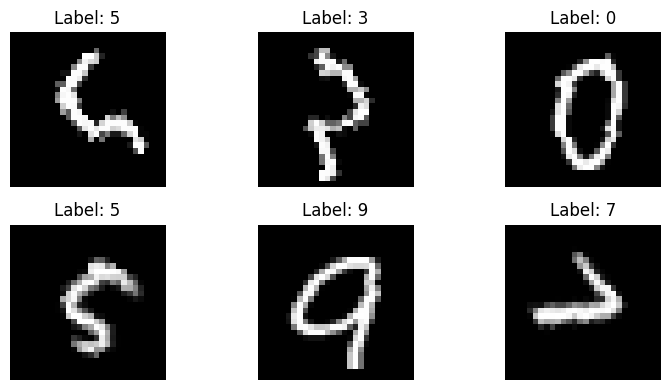

In [ ]:
# TODO: Visualize 6 arbitrary images from the train_subset dataset
arbitrary_indices = [100, 500, 1000, 2000, 3000, 4000]
plt.figure(figsize=(8, 4))

for i, index in enumerate(arbitrary_indices):
    plt.subplot(2, 3, i + 1)
    plt.imshow(train_dataset[index][0].squeeze(), cmap='gray')
    plt.title('Label: {}'.format(train_dataset[index][1]))
    plt.axis('off')
    plt.grid(False)

plt.tight_layout()
plt.show()

## Part 4: Logistic Regression

We will first start by building a logistic regression model to classify the images. We have seen Logistic Regression before, but this time we will use PyTorch to build the model.


In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: initialize the neural network layers (flatten, and then sequential with a Linear Layer(28 * 28, 10), and a sigmoid activation)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(28 * 28, 10)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # TODO: define the forward pass and return outputs (call the layers in the init function in sequence here)
        x = self.flatten(x)        # Flatten the input
        x = self.linear(x)         # Pass through the linear layer
        return x

**TODOs:**

1.  **Instantiate Logistic Regression:**

    - Create a logistic regression model and assign it to the variable `logreg`. Ensure that the model is moved to the GPU device for optimized computation.

2.  **Set Loss Criterion:**

    - Define the loss criterion as `CrossEntropyLoss`. For detailed information, consult the PyTorch [documentation on loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions). Remember, `CrossEntropyLoss` inherently applies softmax, so there's no need to include an additional softmax layer in your model.

3.  **Complete the Training Loop:**

    - Fill in the missing sections in the training loop as indicated by the `#TODO` comments. This involves correctly updating the model weights through backpropagation and managing gradients.

4.  **Track Training Accuracy:**

    - For each training epoch, record the accuracy into a list named `acc_LIST_log`. Make sure the recorded values are of type float.

5.  **Track Average Loss:**

    - Similarly, log the average loss per epoch into a list called `loss_LIST_log`, ensuring the data type is float.

**Additional Instructions:**

- Use the `train_loader` for training the logistic regression model.
- The optimizer should be Adam with a learning rate of 1e-4.
- **Important:** If you observe an increase in loss during training, review the model implementation for potential errors. Accurate implementation should not result in loss increments.

**Note:** Ensure that both `acc_LIST_log` and `loss_LIST_log` contain data as floats, not tensors.


In [ ]:
%%time
# TODO: Instantiate the model
logreg = LogisticRegressionModel().to(device)

# TODO: Set the loss criterion to be Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# TODO: Set the optimizer to be Adam with a learning rate of 1e-4
optimizer = optim.Adam(logreg.parameters(), lr=1e-4)

epoch = 10

loss_LIST_log = []
acc_LIST_log = []

# Train the Model
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Float
      inputs, labels = inputs.to(device), labels.to(device)

      ## TODO
      # Step 1: Reset the optimizer tensor gradient every mini-batch
      optimizer.zero_grad()

      # Step 2: Feed the network the train data
      outputs = logreg(inputs)

      # Step 3: Get the prediction using argmax
      _, predicted = torch.max(outputs, 1)

      # Step 4: Find average loss for one mini-batch of inputs
      loss = criterion(outputs, labels)

      # Step 5: Do a back propagation
      loss.backward()

      # Step 6: Update the weight using the gradients from back propagation by learning step
      optimizer.step()
      # Step 7: Get loss and add to accumulated loss for each epoch
      running_loss += loss.item()
      # Step 8: Get number of correct prediction and increment the number of correct and total predictions after this batch
      # Hint: we need to detach the numbers from GPU to CPU, which stores accuracy and loss
      correct += (predicted == labels).sum().item()
      total += labels.size(0)


  # Step 9: Calculate training accuracy for each epoch (should multiply by 100 to get percentage), store in variable called 'accuracy', and add to acc_LIST_log
  accuracy = 100 * correct / total
  acc_LIST_log.append(accuracy)

  # Step 10: Get average loss for each epoch and add to loss_LIST_log
  epoch_loss = running_loss / len(train_loader)
  loss_LIST_log.append(epoch_loss)
  # Step 11: Print the loss and accuracy for each epoch
  print(f'Epoch [{epoch + 1}/{epoch}] Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%')

Epoch [1/0] Loss: 1.6910, Accuracy: 45.54%
Epoch [2/1] Loss: 1.2638, Accuracy: 61.10%
Epoch [3/2] Loss: 1.1634, Accuracy: 63.80%
Epoch [4/3] Loss: 1.1105, Accuracy: 64.93%
Epoch [5/4] Loss: 1.0787, Accuracy: 65.98%
Epoch [6/5] Loss: 1.0668, Accuracy: 66.39%
Epoch [7/6] Loss: 1.0539, Accuracy: 67.07%
Epoch [8/7] Loss: 1.0423, Accuracy: 67.31%
Epoch [9/8] Loss: 1.0519, Accuracy: 67.28%
Epoch [10/9] Loss: 1.0376, Accuracy: 67.86%
CPU times: user 5min 50s, sys: 1.36 s, total: 5min 51s
Wall time: 5min 53s


Use your matplotlib skills to visualize the training process. Plot the training accuracy and loss over the epochs.


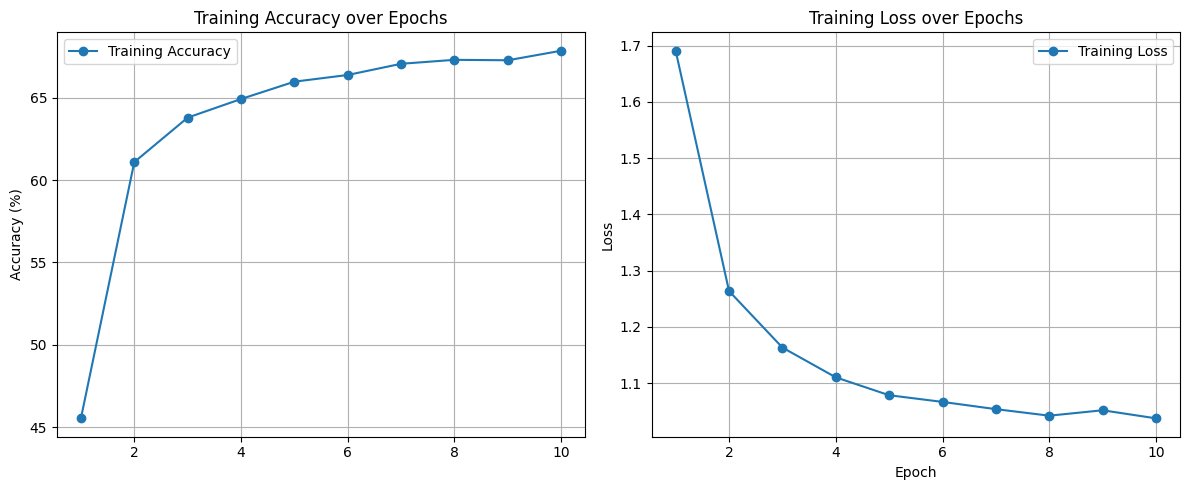

In [ ]:
plt.figure(figsize=(12, 5))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, len(acc_LIST_log) + 1), acc_LIST_log, label='Training Accuracy', marker='o', linestyle='-')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy over Epochs')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(loss_LIST_log) + 1), loss_LIST_log, label='Training Loss', marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Run the trained logistic regression model on the test set and report the accuracy.


In [ ]:
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.type(torch.LongTensor)
        images, labels = images.to(device), labels.to(device)
        # TODO: Get the outputs by passing the test data through the model
        outputs =  logreg(images)
        # TODO: Get the prediction using argmax
        _, predicted = torch.max(outputs.data, 1)
        # TODO: Get number of correct prediction and add to correct and total
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# TODO: Calculate test accuracy for logistic regression (should multiply by 100)
test_acc_log =  100 * correct / total

# TODO: Print the test accuracy
print(f'Test Accuracy: {test_acc_log:.2f}%')


Test Accuracy: 68.68%


## Part 5: Neural Network

Now that you have built the logistic regression model, you probably noticed that the accuracy is not very high. This is because logistic regression is a linear model, and is not very good at capturing the complex relationships in this sort of problem setting. Let's try a conventional neural network model to see if we can improve the accuracy (feedforward neural network).

We will create a feedforward neural network (FNN) with 1 hidden layer with 256 output units (note that the last layer should have 10 output units, corresponding to the 10 classes).

A key question to consider is the choice of activation function. Feel free to play around with different activation functions and see how they affect the model's performance. Follow the slides and add activations to each of the hidden layers.


In [ ]:
class FNN(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: initialize the neural network layers
        self.flatten = nn.Flatten()
        self.hidden_layer = nn.Linear(28 * 28, 256)
        self.activation = nn.ReLU()
        self.output_layer = nn.Linear(256, 10)

    def forward(self, x):
        # TODO: define the forward pass and return outputs
        x = self.flatten(x)
        x = self.hidden_layer(x)
        x = self.activation(x)
        x = self.output_layer(x)
        return x

**TODOs**

1.  **Initialize the FNN Model:**

    - Assign your Feedforward Neural Network (FNN) model to the variable `fnn`. Ensure the model is transferred to the appropriate device environment for efficient computation.

2.  **Define the Loss Function:**

    - Use `CrossEntropyLoss` as the loss function for this model. Consult the [PyTorch documentation on loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions) for more information. This function is suitable for classification tasks and automatically applies the softmax layer.

3.  **Complete Training Loop:**

    - Address the incomplete sections within the training loop as indicated. Properly manage weight updates and gradients during backpropagation.

4.  **Record Training Accuracy:**

    - Store the accuracy of each epoch in a list named `acc_LIST_FNN`. Ensure that these values are stored as floats.

5.  **Log Average Loss:**

    - Similarly, keep track of the average loss per epoch in a list named `loss_LIST_FNN`, ensuring the values are in float format.

**Guidelines:**

- The optimizer for this task is predefined as Adam, with a learning rate of 1e-4.
- To properly handle gradients, invoke `optimizer.zero_grad()` to reset gradients before each `.backward()` operation.
- **Caution:** An increase in loss during training indicates a potential issue with the model's implementation. It's crucial to review and correct any errors in such cases.

**Execution Time:**

- The execution of the following code block is estimated to take approximately 4-5 minutes.

**Note:** Both `acc_LIST_FNN` and `loss_LIST_FNN` must only contain values of type float, not tensors.


In [ ]:
%%time
# Sending the data to device (CPU or GPU)
# TODO instantiate the FNN model to variable fnn
fnn = FNN().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Set the loss criterion as CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Set the optimizer as Adam with a learning rate of 1e-4
optimizer = optim.Adam(fnn.parameters(), lr=1e-4)

epoch = 10

acc_LIST_FNN = []
loss_LIST_FNN = []
# Train the FNN
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Long
      inputs, labels = inputs.to(device), labels.to(device)

      ## TODO
      # Step 1: Reset the optimizer tensor gradient every mini-batch
      optimizer.zero_grad()
      # Step 2: Feed the network the train data
      outputs = fnn(inputs)
      # Step 3: Get the prediction using argmax
      _, predicted = torch.max(outputs.data, 1)
      # Step 4: Find average loss for one mini-batch of inputs
      loss = criterion(outputs, labels)
      # Step 5: Do a back propagation
      loss.backward()
      # Step 6: Update the weight using the gradients from back propagation by learning step
      optimizer.step()
      # Step 7: Get loss and add to accumulated loss for each epoch
      running_loss += loss.item()
      # Step 8: Get number of correct prediction and increment the number of correct and total predictions after this batch
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  # Step 9: Calculate training accuracy for each epoch (should multiply by 100 to get percentage), store in variable called 'accuracy', and add to acc_LIST_FNN
  accuracy = 100 * correct / total
  acc_LIST_FNN.append(accuracy)
  # Step 10: Get average loss for each epoch and add to loss_LIST_FNN
  avg_loss = running_loss / len(train_loader)
  loss_LIST_FNN.append(avg_loss)

  # Step 11: Print the loss and accuracy for each epoch
  print(f'Epoch [{epoch + 1}/{epoch}] - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

Epoch [1/0] - Loss: 1.3321, Accuracy: 59.22%
Epoch [2/1] - Loss: 0.9690, Accuracy: 69.99%
Epoch [3/2] - Loss: 0.8381, Accuracy: 74.14%
Epoch [4/3] - Loss: 0.7410, Accuracy: 77.32%
Epoch [5/4] - Loss: 0.6696, Accuracy: 79.68%
Epoch [6/5] - Loss: 0.6113, Accuracy: 81.85%
Epoch [7/6] - Loss: 0.5617, Accuracy: 83.10%
Epoch [8/7] - Loss: 0.5283, Accuracy: 84.27%
Epoch [9/8] - Loss: 0.4892, Accuracy: 85.40%
Epoch [10/9] - Loss: 0.4656, Accuracy: 85.87%
CPU times: user 5min 51s, sys: 1.26 s, total: 5min 52s
Wall time: 5min 55s


Use your matplotlib skills to visualize the training process. Plot the training accuracy and loss over the epochs.


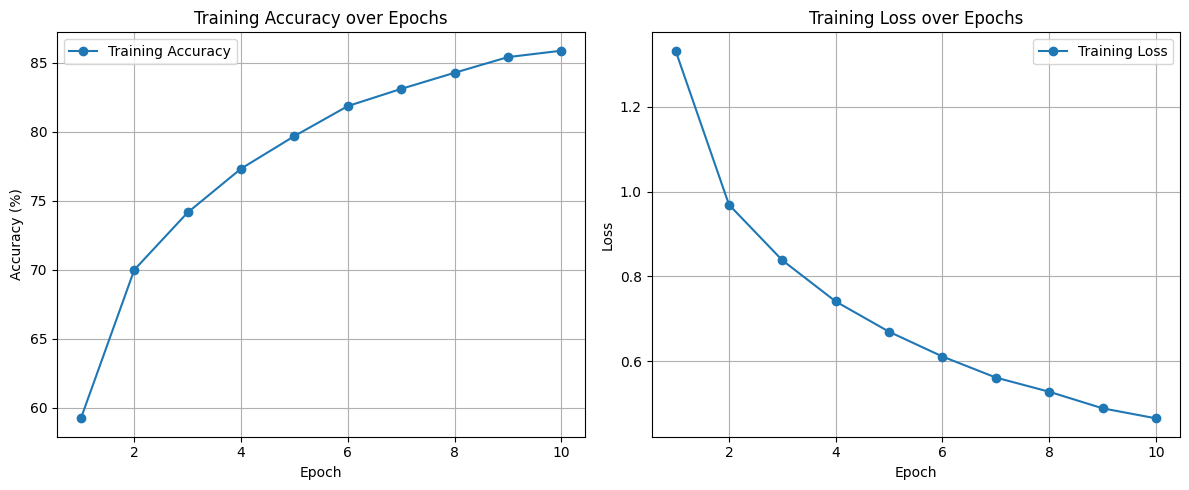

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(acc_LIST_FNN) + 1), acc_LIST_FNN, label='Training Accuracy', marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy over Epochs')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(loss_LIST_FNN) + 1), loss_LIST_FNN, label='Training Loss', marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Now, run the trained FNN model on the test set and report the accuracy.


In [ ]:
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.type(torch.LongTensor)
        images, labels = images.to(device), labels.to(device)

        # TODO: Get the outputs by passing the test data through the model
        outputs = fnn(images)

        # TODO: Get the prediction using argmax
        _, predicted = torch.max(outputs, 1)

        # TODO: Get number of correct prediction and add to correct and total
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# TODO: Calculate test accuracy for FNN (should multiply by 100)
test_acc_FNN = (correct / total) * 100

# Print the test accuracy
print(f'Test Accuracy of FNN: {test_acc_FNN:.2f}%')


Test Accuracy of FNN: 87.00%


## Part 6: Convolutional Neural Network [EC (Optional)]

Finally, we will build a convolutional neural network (CNN) to classify the images. CNNs are particularly good at image recognition tasks, and we should expect to see a significant improvement in accuracy compared to the logistic regression and feedforward neural network models.

In this task, you will design a Convolutional Neural Network (CNN) architecture using PyTorch. The key components of CNNs include:

- Convolutional Layers
- Pooling Layers
- Linear (Fully Connected) Layers
- Activation Functions

**CNN Architecture Requirements:**

Your CNN model should be structured into one or more blocks, with each block comprising the following sequence:

1.  **Convolutional Layer:** This layer applies a set of learnable filters to the input image, capturing spatial features.
2.  **Activation Function:** Following the convolutional layer, an activation function introduces non-linearity to the model, enabling it to learn more complex patterns. Common choices include ReLU (Rectified Linear Unit).
3.  **Max Pooling:** A pooling layer reduces the dimensionality of the data, enhancing the detection of features by summarizing the presence of features in patches of the feature map.

After passing through one or more of these blocks, the output should be:

4.  **Flattened:** The multi-dimensional output from the convolutional blocks is flattened into a single vector to serve as input for the dense layers.
5.  **Linear Layers:** One or more fully connected (dense) layers follow, where each layer is followed by an activation function, except the final layer.
6.  **Output Layer:** The last dense layer's output shape must match the number of classes in your dataset. This layer typically does not have an activation function if you're using a loss function like `CrossEntropyLoss`, which incorporates softmax.

**Design Considerations:**

- For the purposes of this assignment, limit the architecture to no more than two or three convolutional blocks to prevent overly complex models.
- Ensure the final output layer's size corresponds precisely to the number of classes for accurate classification.


To calculate the dimensions of the feature maps at various stages of a Convolutional Neural Network (CNN), especially when dealing with square images, we can create a function that computes the size of the output feature map given the input size, filter size, stride, and padding applied in both convolutional and pooling layers. This calculation is crucial for determining the correct input size for the fully connected layers that follow the convolutional layers in the network.

Here's a generalized function in Python that computes the output dimension of a feature map given these parameters:


In [ ]:
def calculate_output_dimension(input_size, filter_size, stride, padding):
    """
    Calculate the output dimension of a feature map.

    Args:
    - input_size (int): The height/width of the input feature map (assuming a square).
    - filter_size (int): The height/width of the filter (kernel) used (assuming a square).
    - stride (int): The stride with which the filter is applied.
    - padding (int): The amount of padding applied to the input feature map.

    Returns:
    - int: The height/width of the output feature map (assuming a square).
    """


    return ((input_size - filter_size + 2 * padding) // stride) + 1


This function assumes the images are square, meaning the height and width are equal. This simplification is common in many CNN architectures, especially when working with datasets of standardized image sizes (e.g., CIFAR-10, MNIST).

To apply this function, simply plug in the specific values for each convolutional or pooling layer in your network to understand the dimensions at each stage. This is crucial for designing the network architecture, particularly for specifying the input size to the first fully connected layer after the convolutional layers.


**TODOs:**

In your `__init__` method:

1.  Construct between one to three `convolutional blocks`, each comprising a convolution layer, an activation function, and a pooling layer.
2.  `Flatten` the output from the convolutional stages into a tensor.
3.  Set up between one to three `fully-connected layers`.

In your `forward` method (`def forward(self, x)`): 4. Implement the `forward` pass using the layers defined in the `__init__` method.

---

- **Note:** While the specifics of the convolution layers may differ, you might opt to utilize identical pooling layers and activation functions across all blocks. Should you choose uniform parameters for these components, a single instantiation of the pooling layer and the activation function is sufficient.
- **Hint 1:** Leverage the `calculate_output_dimension` function along with the comments on input_dim and output_dim to monitor the dimensions flowing through each layer.
- **Hint 2:** The dimensions you calculate are crucial for determining the input size for the initial fully-connected layer.
- **Hint 3:** Each input to your network is a 28x28 image with a single color channel (gray-scale).
- **Hint 4:** Ensure that the output size of the final fully-connected layer matches the number of classes in your dataset.


In [ ]:
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: initialize the neural network layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Adjusted fully connected layers
        self.fc1 = nn.Linear(64 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # TODO
        # Step 1. Pass the images (x) through convolution block 1 and (block 2, 3 if you have built them)
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        # Step 2. Flatten the image
        x = x.view(-1, 64 * 14 * 14)

        # Step 3. Pass the output through the fully-connected layers (remember to include activation function(s))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



**TODOs**

1.  **Initialize the CNN Model:**

    - Assign your Convolutional Neural Network model to the variable `cnn` and ensure it's moved to the appropriate computational device.

2.  **Define the Loss Function:**

    - Use `CrossEntropyLoss` as your criterion for model evaluation. For further details, refer to the [PyTorch documentation on loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions).

3.  **Complete the Training Loop:**

    - Address the incomplete sections within the training loop to ensure proper model training.

4.  **Compute Training Accuracy:**

    - For each epoch, calculate the training accuracy. Convert the accuracy to percentage form and store these values in a variable named `accuracy`.

5.  **Log Training Accuracy:**

    - Record the training accuracy for every epoch in a list named `acc_LIST_CNN`.

6.  **Log Average Loss:**

    - Similarly, maintain a record of the average loss per epoch in a list called `loss_LIST_CNN`.

**Fixed Parameters:**

- **Optimizer:** The model uses Adam as its optimizer.
- **Epochs:** Training will proceed for 10 epochs.

---

**Hints and Notes:**

- **Weight Updates:** To facilitate proper backpropagation, remember to clear the gradients before each backward pass by calling `optimizer.zero_grad()`.
- **Model Implementation Check:** If you notice an increase in loss during training, reassess your model's implementation for potential errors.
- **Training Duration:** Typically, training should be completed within 5 to 10 minutes.
- **Data Types:** Ensure that `acc_LIST_CNN` and `loss_LIST_CNN` contain values as floats, not tensors.


In [ ]:
%%time
# Sending the data to device (CPU or GPU)
# TODO: instantiate the CNN model to variable cnn
cnn =  CNN().to(device)

# TODO: set the loss criterion as CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# TODO: set the optimizer as Adam with a learning rate of 1e-4
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-4)

epoch = 10

acc_LIST_CNN = []
loss_LIST_CNN = []

# Train the CNN
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Float
      inputs, labels = inputs.to(device), labels.to(device)
      ## TODO
      # Step 1: Reset the optimizer tensor gradient every mini-batch
      optimizer.zero_grad()
      # Step 2: Feed the network the train data
      outputs = cnn(inputs)
      # Step 3: Get the prediction using argmax
      _, predicted = torch.max(outputs, 1)
      # Step 4: Find average loss for one mini-batch of inputs
      loss = criterion(outputs, labels)
      # Step 5: Do a back propagation
      loss.backward()
      # Step 6: Update the weight using the gradients from back propagation by learning step
      optimizer.step()
      # Step 7: Get loss and add to accumulated loss for each epoch
      running_loss += loss.item()


      # Step 8: Get number of correct prediction and increment the number of correct and total predictions after this batch
      # Hint: we need to detach the numbers from GPU to CPU, which stores accuracy and loss
      correct += (predicted == labels).sum().item()
      total += labels.size(0)

  # Step 9: Calculate training accuracy for each epoch (should multiply by 100 to get percentage), store in variable called 'accuracy', and add to acc_LIST_CNN
  accuracy = 100 * correct / total
  acc_LIST_CNN.append(accuracy)
  # Step 10: Get average loss for each epoch and add to loss_LIST_CNN
  avg_loss = running_loss / len(train_loader)
  loss_LIST_CNN.append(avg_loss)
  # Step 11: Print the loss and accuracy for each epoch
  print(f"Epoch [{epoch+1}/{epoch}] - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")


Epoch [1/0] - Loss: 0.7816, Accuracy: 75.58%
Epoch [2/1] - Loss: 0.3455, Accuracy: 89.30%
Epoch [3/2] - Loss: 0.2686, Accuracy: 91.70%
Epoch [4/3] - Loss: 0.2231, Accuracy: 93.06%
Epoch [5/4] - Loss: 0.1952, Accuracy: 93.96%
Epoch [6/5] - Loss: 0.1751, Accuracy: 94.56%
Epoch [7/6] - Loss: 0.1506, Accuracy: 95.30%
Epoch [8/7] - Loss: 0.1400, Accuracy: 95.63%
Epoch [9/8] - Loss: 0.1245, Accuracy: 96.09%
Epoch [10/9] - Loss: 0.1189, Accuracy: 96.22%
CPU times: user 6min 20s, sys: 1.29 s, total: 6min 21s
Wall time: 6min 27s


You know the drill. Use your matplotlib skills to visualize the training process. Plot the training accuracy and loss over the epochs.


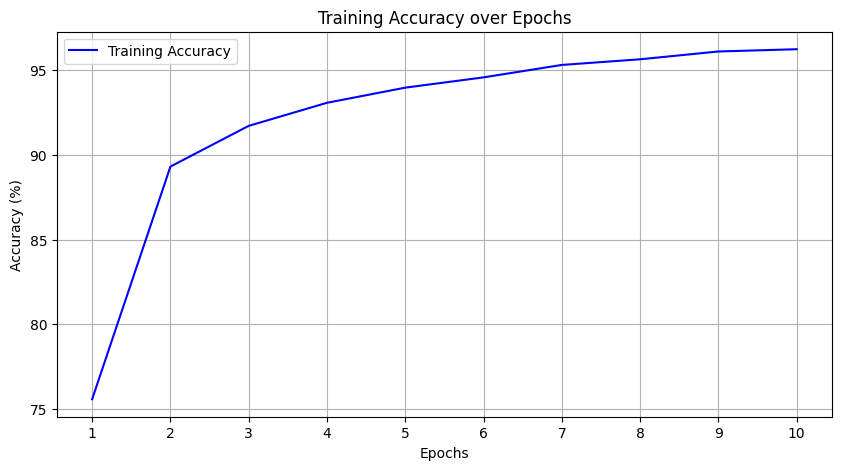

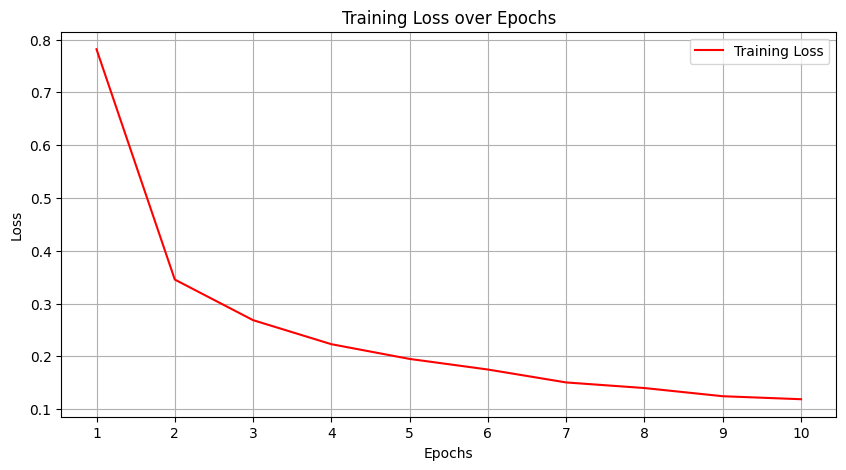

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(acc_LIST_CNN) + 1), acc_LIST_CNN, label='Training Accuracy', color='blue')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, len(acc_LIST_CNN) + 1))
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(loss_LIST_CNN) + 1), loss_LIST_CNN, label='Training Loss', color='red')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, len(loss_LIST_CNN) + 1))
plt.grid(True)
plt.legend()
plt.show()

Calculate the accuracy of the CNN model on the test set.


In [ ]:
# TODO
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.type(torch.LongTensor) # Cast to Float
        images, labels = images.to(device), labels.to(device)
        # TODO
        # Get the output
        outputs = cnn(images)

        # Get the prediction using argmax
        _, predicted = torch.max(outputs, 1)

        # Get number of correct prediction and add to correct and total
        correct += (predicted == labels).sum().item()
        total += labels.size(0)


# Calculate test accuracy for CNN (should multiple by 100)
test_acc_CNN = (correct / total) * 100

# Print the test accuracy
print(f'Test Accuracy for CNN: {test_acc_CNN:.2f}%')

Test Accuracy for CNN: 96.60%


From the test accuracy of the three models, we can see that the CNN model performs the best. This is expected, as CNNs are particularly good at image recognition tasks.

Digit recognition is used in a variety of applications, such as reading postal codes, recognizing handwritten numbers on bank checks, and recognizing numbers on car license plates. The MNIST dataset is a popular dataset for digit recognition, and the models we have built can be used in these applications.


Now, we want to see where the best model (CNN) is making mistakes. We will visualize some of the images that the CNN model is misclassifying. We may wonder, are there certain digits that are more difficult to classify than others? Are there certain images that are more difficult to classify than others? We will explore these questions by visualizing some of the misclassified images. To figure this out we will create a confusion matrix.


In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# Get predictions for the entire test dataset
all_predicted = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn(images)
        _, predicted = torch.max(outputs, 1)
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predicted)

# Visualize confusion matrix as a DataFrame
confusion_matrix_df = pd.DataFrame(conf_matrix, index=range(10), columns=range(10))
print(confusion_matrix_df)

     0    1    2    3    4    5    6    7    8    9
0  449    0    0    0    0    0    0    2    0    0
1    0  590    0    1    0    0    0    0    0    0
2    3    2  484    0    3    0    0    5    4    0
3    1    0    2  503    0    4    0    0    1    0
4    1    3    4    1  464    0    1    2    2    2
5    2    1    0    3    2  436    9    1    3    1
6    5    2    3    0    3    7  477    0    1    1
7    0    5   10    5    2    0    0  487    0   10
8    4    0    9    1    2    2    0    2  444    2
9    4    0    1    0    5    6    0    8    0  500


Visualize the confusion matrix using matplotlib.


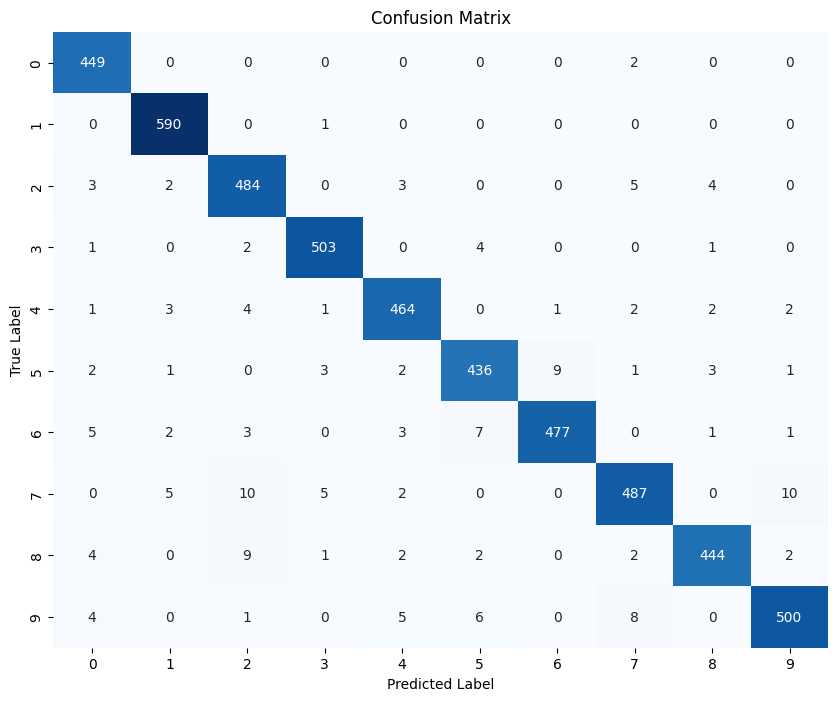

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

What do you observe from the confusion matrix? Are there certain digits that are more difficult to classify than others? Are there certain digits that are easily confused with others?


## Part 7: Applying Knowledge in New Contexts [EC (Optional)]

Now that we've done a tutorial like exercise with the MNIST dataset, let's see if you can apply your knowledge to a new setting with a little less hand holding. You'll work with a dataset of Yelp reviews, aiming to predict the sentiment (positive or negative) of each review based on its content. The dataset comprises 100,000 Yelp reviews, each annotated with a binary rating indicating whether the review is positive (1) or negative (0). The reviews have been pre-processed into a term frequency format, retaining 1,072 significant words. Your task is to develop a neural network model that accurately classifies these reviews using PyTorch. This task is a little more open-ended because we want you to be creative in how you design your model. You can use any of the models you have learned about in this course, and you can experiment with different architectures, activation functions, and hyperparameters. We will provide a few hints and ideas/skeleton code to get you started, but feel free to experiment and try different things.


### Data Preparation

**Objective:**

Prepare the dataset for training and validation, ensuring all data is in the appropriate format (matrices or vectors) for neural network training.

**Tasks:**

1.  Load the Yelp review dataset from the provided CSV file, `YELP_tm_freq.csv`. This file contains pre-processed reviews in term frequency format.
2.  Split the dataset into training and validation sets. Reserve 10,000 samples for validation (`data3_val`) and use the remaining 90,000 samples for training (`data3_train`).
3.  Ensure the training and validation data are structured as matrices (features) and vectors (labels).


In [ ]:
from sklearn.model_selection import train_test_split
yelp_data = pd.read_csv("YELP_tm_freq.csv")
print(yelp_data.columns)

# Step 2: Split the dataset into training and validation sets
train_data, val_data = train_test_split(yelp_data, test_size=0.1, random_state=42)

# Step 3: Prepare the data
# Extract features (term frequencies) and labels from the training and validation sets
X = yelp_data.drop(columns=['user_id', 'date'])
y = yelp_data.iloc[:, -1]   # Labels (last column)

# Convert features to numeric values
X = X.astype(float)

# Step 2: Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Step 3: Convert features and labels to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

# Display the shapes of the tensors
print("Training features shape:", X_train_tensor.shape)
print("Training labels shape:", y_train_tensor.shape)
print("Validation features shape:", X_val_tensor.shape)
print("Validation labels shape:", y_val_tensor.shape)

Index(['user_id', 'stars', 'date', 'rating', 'accept', 'across', 'actual',
       'add', 'addit', 'admit',
       ...
       'yes', 'yet', 'yogurt', 'youd', 'youll', 'young', 'your', 'youv', 'yum',
       'yummi'],
      dtype='object', length=952)
Training features shape: torch.Size([900, 950])
Training labels shape: torch.Size([900])
Validation features shape: torch.Size([100, 950])
Validation labels shape: torch.Size([100])


### Model Design and Training

**Objective:**

Implement and train a fully connected neural network to classify Yelp reviews based on their sentiment.

**Model Architecture:**

- The network should have two hidden layers.
- The first layer should contain 16 neurons, and the second layer should contain 8 neurons. Use ReLU as the activation function for both layers.
- The output layer should use the sigmoid activation function to output the probability of a review being positive.

**Tasks:**

1.  Define the neural network architecture using PyTorch. Use `Sequential` model type and add layers with `Dense`.
2.  Compile the model with the following configurations:
    - Optimizer: RMSprop
    - Loss function: Sparse Categorical Crossentropy
    - Metric: Accuracy
3.  Train the model on the training set. Use a validation split of 15% to monitor the model's performance during training. Train for 20 epochs with a batch size of 512.


In [89]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor((y_train.values > 0.5).astype(float), dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor((y_val.values > 0.5).astype(float), dtype=torch.float32)

# Step 2: Define the neural network architecture
model = nn.Sequential(
    nn.Linear(in_features=X_train.shape[1], out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=8),
    nn.ReLU(),
    nn.Linear(in_features=8, out_features=1),
    nn.Sigmoid()
)

# Step 3: Compile the model
optimizer = optim.RMSprop(model.parameters())
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
metrics = ['accuracy']    # Metric for evaluation

# Step 4: Train the model
batch_size = 512
epochs = 20

for epoch in range(epochs):
    # Shuffle the training data
    permutation = torch.randperm(X_train_tensor.size()[0])
    for i in range(0, X_train_tensor.size()[0], batch_size):
        indices = permutation[i:i + batch_size]
        batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs.squeeze(), batch_y)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

    # Validation
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs.squeeze(), y_val_tensor)
        val_acc = ((val_outputs > 0.5).float() == y_val_tensor).float().mean()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_acc.item():.4f}')

Epoch 1/20, Loss: 0.2356, Validation Loss: 0.4698, Validation Accuracy: 0.9733
Epoch 2/20, Loss: 0.2185, Validation Loss: 0.2410, Validation Accuracy: 0.9733
Epoch 3/20, Loss: 0.1426, Validation Loss: 0.2474, Validation Accuracy: 0.9733
Epoch 4/20, Loss: 0.0868, Validation Loss: 0.2639, Validation Accuracy: 0.9733
Epoch 5/20, Loss: 0.0809, Validation Loss: 0.2551, Validation Accuracy: 0.9733
Epoch 6/20, Loss: 0.0449, Validation Loss: 0.2873, Validation Accuracy: 0.9733
Epoch 7/20, Loss: 0.0442, Validation Loss: 0.3099, Validation Accuracy: 0.9733
Epoch 8/20, Loss: 0.0477, Validation Loss: 0.3433, Validation Accuracy: 0.9733
Epoch 9/20, Loss: 0.0405, Validation Loss: 0.3681, Validation Accuracy: 0.9733
Epoch 10/20, Loss: 0.0356, Validation Loss: 0.3868, Validation Accuracy: 0.9733
Epoch 11/20, Loss: 0.0294, Validation Loss: 0.4166, Validation Accuracy: 0.9733
Epoch 12/20, Loss: 0.0227, Validation Loss: 0.4051, Validation Accuracy: 0.9733
Epoch 13/20, Loss: 0.0170, Validation Loss: 0.435

### Model Evaluation

**Objective:**

Evaluate the performance of your trained model on the validation set and make predictions on new data samples.

**Tasks:**

1.  Assess the model's performance on the validation set. Report the accuracy and loss.
2.  Predict the sentiment of the first five reviews in the validation set. Display the predicted probabilities and the actual labels.

We will give extra credit for the best performing models on the validation set.


In [91]:
with torch.no_grad():
    val_outputs = model(X_val_tensor)
    val_loss = criterion(val_outputs.squeeze(), y_val_tensor)
    val_acc = ((val_outputs > 0.5).float() == y_val_tensor).float().mean()

# Report the accuracy and loss
print(f"Validation Accuracy: {val_acc.item():.4f}")
print(f"Validation Loss: {val_loss.item():.4f}")

Validation Accuracy: 0.9733
Validation Loss: 0.5587


In [ ]:
"""
Review 1:
Predicted Probability: 0.9716
Predicted Label: 1
Actual Label: 1

Review 2:
Predicted Probability: 0.0000
Predicted Label: 0
Actual Label: 0

Review 3:
Predicted Probability: 0.0000
Predicted Label: 0
Actual Label: 0

Review 4:
Predicted Probability: 1.0000
Predicted Label: 1
Actual Label: 1

Review 5:
Predicted Probability: 0.0000
Predicted Label: 0
Actual Label: 0

These predictions indicate that the model performs well on the validation set, correctly classifying the sentiment of the majority of reviews.
"""